In [2]:
import pandas as pd

#Load the dataset
file_path = "/content/sample_data/dataset.csv"
df = pd.read_csv(file_path)

#First few rows
print("\nFirst 5 rows:")
print(df.head())

#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


First 5 rows:
                              name  \
0     2024 Jeep Wagoneer Series II   
1  2024 Jeep Grand Cherokee Laredo   
2         2024 GMC Yukon XL Denali   
3       2023 Dodge Durango Pursuit   
4            2024 RAM 3500 Laramie   

                                         description   make           model  \
0  \n      \n        Heated Leather Seats, Nav Sy...   Jeep        Wagoneer   
1  Al West is committed to offering every custome...   Jeep  Grand Cherokee   
2                                                NaN    GMC        Yukon XL   
3  White Knuckle Clearcoat 2023 Dodge Durango Pur...  Dodge         Durango   
4  \n      \n        2024 Ram 3500 Laramie Billet...    RAM            3500   

   year    price                                             engine  \
0  2024  74600.0                            24V GDI DOHC Twin Turbo   
1  2024  50170.0                                                OHV   
2  2024  96410.0  6.2L V-8 gasoline direct injection, variable v... 

In [3]:
# Separate by data types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Features:", numerical_cols)
print("Categorical Features:", categorical_cols)


Numerical Features: ['year', 'price', 'cylinders', 'mileage', 'doors']
Categorical Features: ['name', 'description', 'make', 'model', 'engine', 'fuel', 'transmission', 'trim', 'body', 'exterior_color', 'interior_color', 'drivetrain']


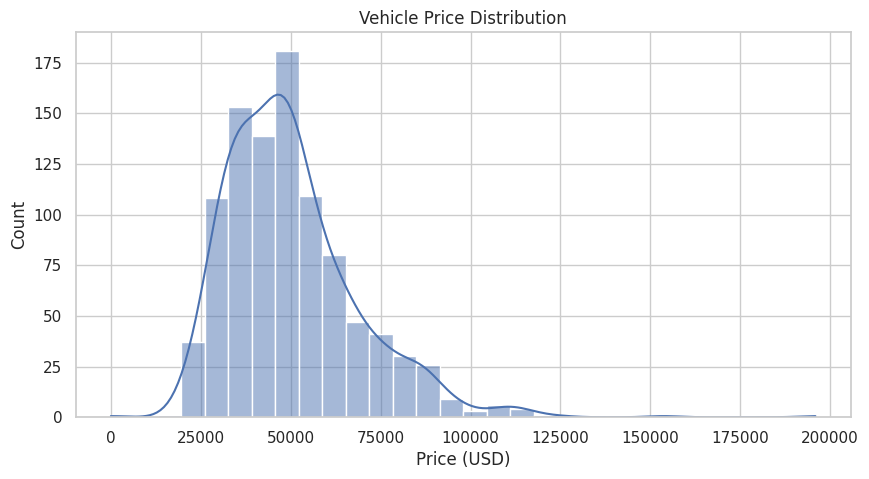

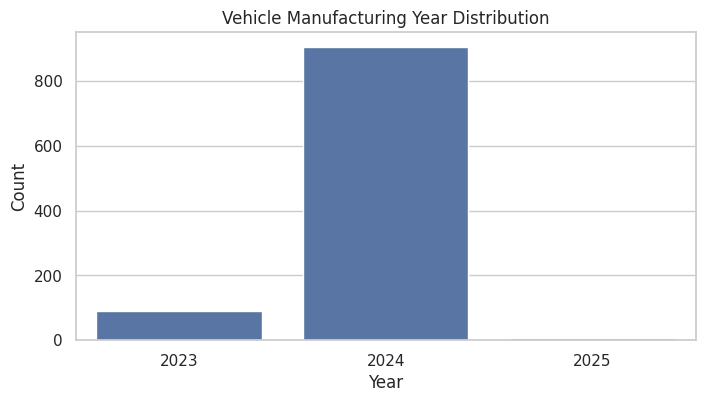

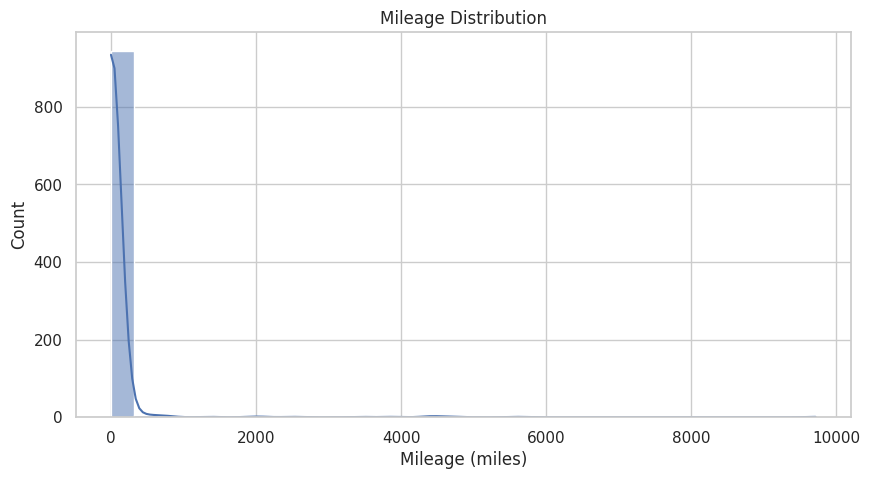

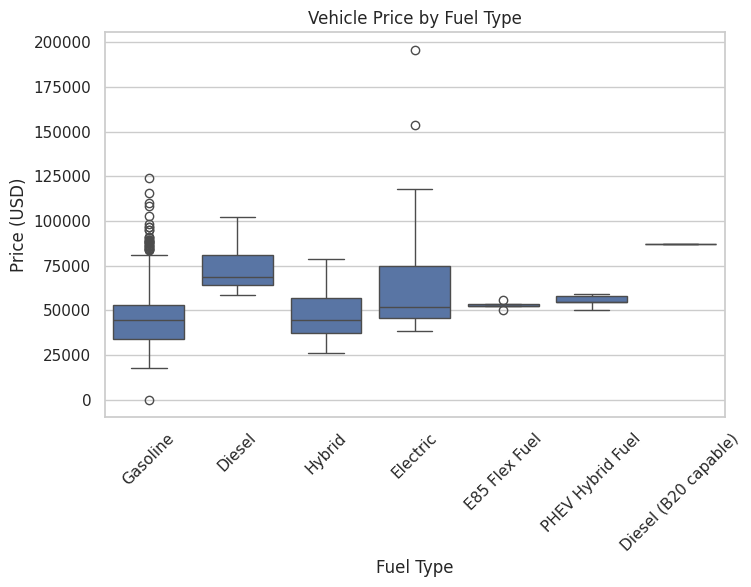

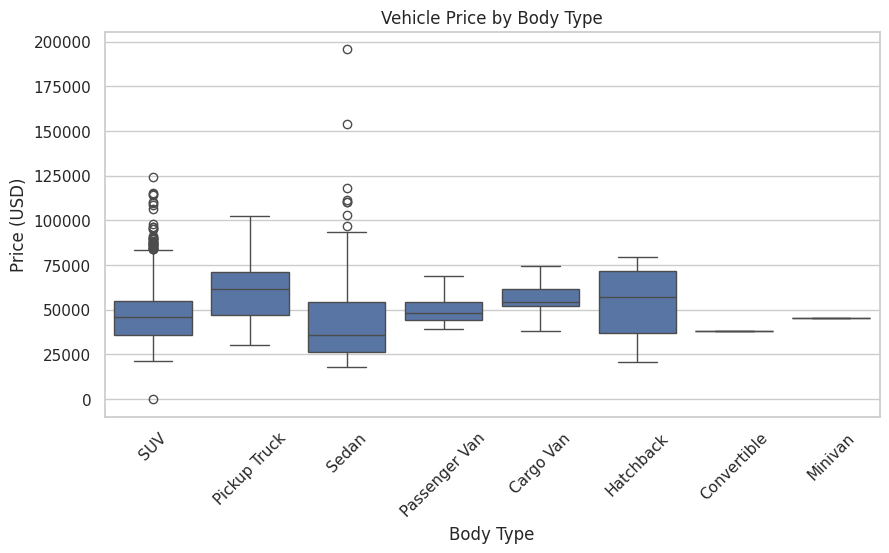

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot 1: Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], kde=True, bins=30)
plt.title("Vehicle Price Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

# Plot 2: Year Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x="year", data=df)
plt.title("Vehicle Manufacturing Year Distribution")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

# Plot 3: Mileage Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['mileage'], kde=True, bins=30)
plt.title("Mileage Distribution")
plt.xlabel("Mileage (miles)")
plt.ylabel("Count")
plt.show()

# Plot 4: Price by Fuel Type
plt.figure(figsize=(8, 5))
sns.boxplot(x="fuel", y="price", data=df)
plt.title("Vehicle Price by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.show()

# Plot 5: Price by Body Type
plt.figure(figsize=(10, 5))
sns.boxplot(x="body", y="price", data=df)
plt.title("Vehicle Price by Body Type")
plt.xlabel("Body Type")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Data Preprocessing

# Drop rows with missing value (price)
df.dropna(subset=['price'], inplace=True)

# Fill missing categorical values with mode
for col in categorical_cols:
  if col in df.columns:
    df.fillna({col: df[col].mode()[0]}, inplace=True)

# Fill missing numerical values with median
for col in numerical_cols:
  if col in df.columns:
    df.fillna({col: df[col].median()}, inplace=True)

# Drop unwanted columns
df.drop(columns=[col for col in ['name', 'description'] if col in df.columns], inplace=True)

# Encode categorical columns
encode_cols = categorical_cols
df = pd.get_dummies(df, columns=[col for col in encode_cols if col in df.columns], drop_first=True)

print("Final shape of dataset: ", df.shape)
df.info()

Final shape of dataset:  (979, 880)
<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 1001
Columns: 880 entries, year to drivetrain_Rear-wheel Drive
dtypes: bool(875), float64(4), int64(1)
memory usage: 882.4 KB


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Split data
X = df.drop('price', axis=1)
y = df['price']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
  print(f"\nEvaluation for {model_name}:")
  print("MAE :", mean_absolute_error(y_true, y_pred))
  print("RMSE :", np.sqrt(mean_squared_error(y_true, y_pred)))
  print("R² :", r2_score(y_true, y_pred))

# Evaluating both models
evaluate_model(y_test, lr_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest")


Evaluation for Linear Regression:
MAE : 4701.522955232369
RMSE : 7795.573040096124
R² : 0.8010056513573991

Evaluation for Random Forest:
MAE : 4743.974267129837
RMSE : 8738.970455491053
R² : 0.7499279265616503


In [27]:
import optuna
from sklearn.model_selection import cross_val_score

# Optuna objective function
def objective(trial):
  # Defining the hyperparameter search space
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

  # Initialize model
  model = RandomForestRegressor(
      n_estimators = n_estimators,
      max_depth = max_depth,
      min_samples_split = min_samples_split,
      random_state = 42,
      n_jobs = 1
  )

  # Cross validation
  score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

  return -score.mean()


# Create and run the study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best Hyperparameters:", study.best_params)
print("Best CrossValidated MAE:", study.best_value)

[I 2025-07-08 08:22:00,080] A new study created in memory with name: no-name-6486854c-aae6-409d-9cc3-091267adcdfa
[I 2025-07-08 08:22:15,104] Trial 0 finished with value: 5236.197725606969 and parameters: {'n_estimators': 385, 'max_depth': 40, 'min_samples_split': 8}. Best is trial 0 with value: 5236.197725606969.
[I 2025-07-08 08:22:20,413] Trial 1 finished with value: 5764.302729784206 and parameters: {'n_estimators': 232, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 5236.197725606969.
[I 2025-07-08 08:22:37,111] Trial 2 finished with value: 5274.902579645364 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 9}. Best is trial 0 with value: 5236.197725606969.
[I 2025-07-08 08:22:54,179] Trial 3 finished with value: 5053.925462621795 and parameters: {'n_estimators': 477, 'max_depth': 26, 'min_samples_split': 4}. Best is trial 3 with value: 5053.925462621795.
[I 2025-07-08 08:23:07,241] Trial 4 finished with value: 5038.106921634132 and

Best Hyperparameters: {'n_estimators': 306, 'max_depth': 50, 'min_samples_split': 2}
Best CrossValidated MAE: 4945.607714885043


In [31]:
# Train final model
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate test set
preds = final_model.predict(X_test)

# Printinf final results
print("Final MAE:", mean_absolute_error(y_test, preds))
print("Final RMSE:", np.sqrt(np.mean((y_test - preds)**2)))
print("Final R²:", final_model.score(X_test, y_test))

Final MAE: 4629.1256614038475
Final RMSE: 8433.028431313782
Final R²: 0.7671309444215814


Model Deployment

In [39]:
def prepare_input(data_dict, reference_df):
    """
    data_dict: dictionary of inputs like a vehicle's details
    reference_df: the one-hot encoded training DataFrame (df)
    """
    import pandas as pd

    # Create a single-row DataFrame from user input
    input_df = pd.DataFrame([data_dict])

    # Apply same preprocessing (e.g., one-hot encoding) using reference_df's columns
    input_df_encoded = pd.get_dummies(input_df)

    # Align with training data columns (fill missing with 0)
    input_df_encoded = input_df_encoded.reindex(columns=reference_df.drop('price', axis=1).columns, fill_value=0)

    return input_df_encoded

sample_input = {
    'year': 2024,
    'mileage': 12.0,
    'cylinders': 6.0,
    'doors': 2.0,
    'make': 'BMW',
    'model': 'M4',
    'fuel': 'Gasoline',
    'transmission': '7-Speed Double-clutch',
    'trim': 'F80',
    'body': 'Coupe',
    'exterior_color': 'Black',
    'interior_color': 'Red',
    'drivetrain': 'Rear-wheel Drive',
    'engine': '3.0L I6 Turbo'
}

# Run prediction
# Prepare input
X_live = prepare_input(sample_input, df)

# Predict
predicted_price = final_model.predict(X_live)[0]
print(f"Predicted Vehicle Price: ${predicted_price:,.2f}")


Predicted Vehicle Price: $58,662.35
